In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.logging.set_verbosity(tf.logging.ERROR)

#### Load Data
We're using a filtered version of Cat & Dog data on Kaggle provided by Microsoft research

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 0s 0us/step


The dataset we have downloaded has the following directory structure. 

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [4]:
#on Linux
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print 

/tmp/.keras/datasets
/tmp/.keras/datasets/cats_and_dogs_filtered
/tmp/.keras/datasets/cats_and_dogs_filtered/train
/tmp/.keras/datasets/cats_and_dogs_filtered/train/cats
/tmp/.keras/datasets/cats_and_dogs_filtered/train/dogs
/tmp/.keras/datasets/cats_and_dogs_filtered/validation
/tmp/.keras/datasets/cats_and_dogs_filtered/validation/cats
/tmp/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [5]:
# on Windows
#!tree $zip_dir_base

In [6]:
#Assign variables to the paths accordingly
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


#### SETTING MODEL PARAMETERS

In [9]:
BATCH_SIZE = 100
IMG_SHAPE = 150

#### DATA PREPARATION

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

We can do this using the **tf.keras.preprocessing.image.ImageDataGenerator** class

In [10]:
# While using the generator, we will scale images down from a 0-255 range to a 0-1 range
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for validation data

Use `flow_from_directory` method to load images, apply rescaling and resize images.

In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_SHAPE,IMG_SHAPE),#150 x 150
                                                          class_mode='binary')#binary labeled data

Found 2000 images belonging to 2 classes.


In [12]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=validation_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_SHAPE,IMG_SHAPE),#150 x 150
                                                          class_mode='binary')#binary labeled data

Found 1000 images belonging to 2 classes.


#### VISUALIZING TRAINING IMAGES

In [13]:
sample_training_images, _ = next(train_data_gen)

In [14]:
#plot images -- one row, 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1,5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

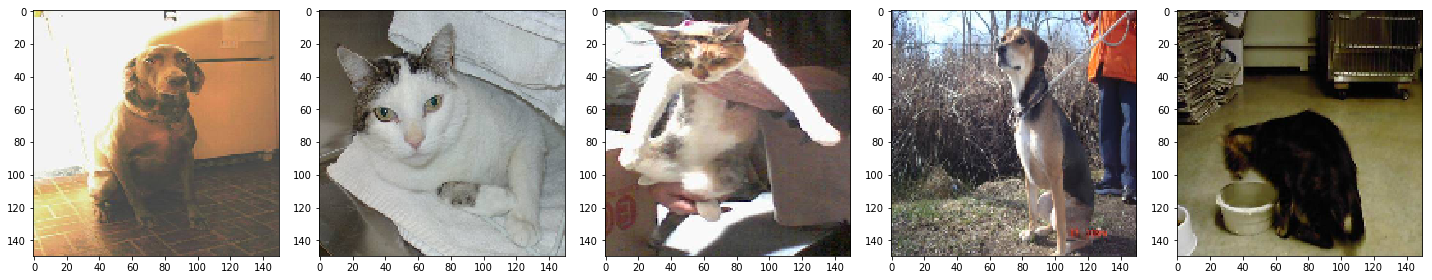

In [15]:
plotImages(sample_training_images[:5])

### Creating the model

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3),activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [17]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [18]:
#model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

##### Train the model:
Since the batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`

In [19]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 11s 531ms/step - loss: 0.7072 - acc: 0.4910 - val_loss: 0.6921 - val_acc: 0.5970
Epoch 2/100
20/20 [==============================] - 7s 372ms/step - loss: 0.6902 - acc: 0.5525 - val_loss: 0.6719 - val_acc: 0.6170
Epoch 3/100
20/20 [==============================] - 7s 374ms/step - loss: 0.6636 - acc: 0.5985 - val_loss: 0.6366 - val_acc: 0.6570
Epoch 4/100
20/20 [==============================] - 7s 365ms/step - loss: 0.6342 - acc: 0.6480 - val_loss: 0.6355 - val_acc: 0.6410
Epoch 5/100
20/20 [==============================] - 7s 367ms/step - loss: 0.6188 - acc: 0.6585 - val_loss: 0.6045 - val_acc: 0.6840
Epoch 6/100
20/20 [==============================] - 7s 358ms/step - loss: 0.5734 - acc: 0.6940 - val_loss: 0.5767 - val_acc: 0.7040
Epoch 7/100
20/20 [==============================] - 7s 368ms/step - loss: 0.5304 - acc: 0.7320 - val_loss: 0.5437 - val_acc: 0.7370
Epoch 8/100
20/20 [==============================] - 7s 375ms/step -

Epoch 39/100
20/20 [==============================] - 7s 363ms/step - loss: 2.6712e-04 - acc: 1.0000 - val_loss: 1.4836 - val_acc: 0.7750
Epoch 40/100
20/20 [==============================] - 7s 345ms/step - loss: 2.3205e-04 - acc: 1.0000 - val_loss: 1.5007 - val_acc: 0.7740
Epoch 41/100
20/20 [==============================] - 7s 351ms/step - loss: 2.0575e-04 - acc: 1.0000 - val_loss: 1.5122 - val_acc: 0.7770
Epoch 42/100
20/20 [==============================] - 7s 348ms/step - loss: 1.8337e-04 - acc: 1.0000 - val_loss: 1.5259 - val_acc: 0.7740
Epoch 43/100
20/20 [==============================] - 7s 351ms/step - loss: 1.6250e-04 - acc: 1.0000 - val_loss: 1.5406 - val_acc: 0.7770
Epoch 44/100
20/20 [==============================] - 8s 379ms/step - loss: 1.4448e-04 - acc: 1.0000 - val_loss: 1.5518 - val_acc: 0.7760
Epoch 45/100
20/20 [==============================] - 8s 390ms/step - loss: 1.3098e-04 - acc: 1.0000 - val_loss: 1.5637 - val_acc: 0.7780
Epoch 46/100
20/20 [==============

Epoch 76/100
20/20 [==============================] - 7s 351ms/step - loss: 1.3833e-05 - acc: 1.0000 - val_loss: 1.7914 - val_acc: 0.7820
Epoch 77/100
20/20 [==============================] - 7s 358ms/step - loss: 1.3211e-05 - acc: 1.0000 - val_loss: 1.7970 - val_acc: 0.7830
Epoch 78/100
20/20 [==============================] - 8s 408ms/step - loss: 1.2621e-05 - acc: 1.0000 - val_loss: 1.7996 - val_acc: 0.7830
Epoch 79/100
20/20 [==============================] - 7s 361ms/step - loss: 1.2036e-05 - acc: 1.0000 - val_loss: 1.8048 - val_acc: 0.7840
Epoch 80/100
20/20 [==============================] - 7s 358ms/step - loss: 1.1537e-05 - acc: 1.0000 - val_loss: 1.8084 - val_acc: 0.7820
Epoch 81/100
20/20 [==============================] - 8s 383ms/step - loss: 1.1050e-05 - acc: 1.0000 - val_loss: 1.8129 - val_acc: 0.7840
Epoch 82/100
20/20 [==============================] - 7s 358ms/step - loss: 1.0588e-05 - acc: 1.0000 - val_loss: 1.8157 - val_acc: 0.7830
Epoch 83/100
20/20 [==============

### Visualizing results of the training

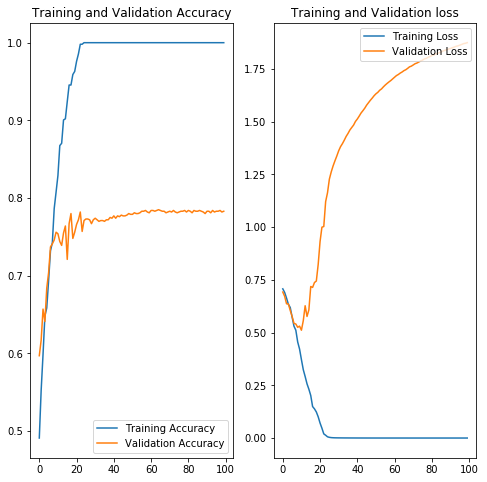

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation loss')

plt.savefig('./foo.png')
plt.show()

**Clearly we are over-fitting. We will fix that soon**